# Compare sPlotOpen to Published Trait Maps

This section covers:

- Load GeoTiff published maps
- Calculate weighted r2 
- Comparison of new iNaturalist maps to Schiller maps

In [1]:
# packages
import os
import pandas as pd
import numpy as np

# plotting
from matplotlib import pyplot as plt
import seaborn as sns

# for calculating grid areas
from pyproj import Proj # allows for different projections 
from shapely.geometry import shape # for calculating areas

In [2]:
# set working directory
os.chdir('/net/home/swolf/iNaturalist/Data')
os.getcwd() 

'/net/home/swolf/iNaturalist/Data'

## Load published maps from GeoTiff

We use xarray to load the geotiffs:

In [3]:
from os import listdir
from os.path import isfile, join
path = "published_maps/05deg/"
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()

In [4]:
import xarray as xr

In [5]:
files

['other_nit_05deg.tif', 'other_nita_05deg.tif', 'other_sla_05deg.tif']

In [6]:
def cubeFile(file):
    name = file.replace(".tif","")
    sr = xr.open_dataset(path + file,engine = "rasterio",chunks = 1024)
    sr = sr.assign_coords({"variable":name})
    return sr

da = xr.concat([cubeFile(x) for x in files],dim = "variable")

In [7]:
da

<xarray.Dataset>
Dimensions:      (band: 6, x: 720, y: 360, variable: 3)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6
  * x            (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * y            (y) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    spatial_ref  int64 0
  * variable     (variable) <U16 'other_nit_05deg' ... 'other_sla_05deg'
Data variables:
    band_data    (variable, band, y, x) float32 dask.array<chunksize=(1, 6, 360, 720), meta=np.ndarray>

Check output by visualizing one band:

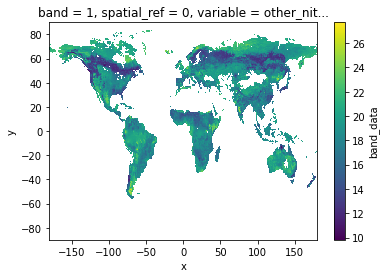

In [8]:
da.sel(band = 1).band_data.sel(variable = 'other_nit_05deg').plot.imshow()

## Calculate weighted r2 for each published map in relation to sPlotOpen

In [9]:
def lat_weights(lat_unique, deg):
    
    from pyproj import Proj
    from shapely.geometry import shape
    
    # determine weights per grid cell based on longitude
    # keep only one exemplary cell at each distance from equator
    # weights per approximated area of grid size depending on distance from equator
    
    # make dictionary
    weights = dict()

    for j in lat_unique:
        
        # the four corner points of the grid cell
        p1 = (0 , j+(deg/2))
        p2 = (deg , j+(deg/2) )
        p3 = (deg, j-(deg/2))
        p4 = (0, j-(deg/2) )
        
    
        # Calculate polygon surface area
        # https://stackoverflow.com/questions/4681737/how-to-calculate-the-area-of-a-polygon-on-the-earths-surface-using-python
        
        co = {"type": "Polygon", "coordinates": [[p1,p2,p3,p4]]}
        lat_1=p3[1]
        lat_2=p1[1]
        lat_0=(p1[1]+p3[1])/2
        lon_0=deg/2
        
        
        # Projection equal area used: https://proj.org/operations/projections/aea.html
        projection_string="+proj=aea +lat_1=" + str(lat_1) + " +lat_2=" + str(lat_2) + " +lat_0=" + str(lat_0) + " +lon_0=" + str(lon_0) 
        lon, lat = zip(*co['coordinates'][0])
        
        pa = Proj(projection_string)
        x, y = pa(lon, lat)
        cop = {"type": "Polygon", "coordinates": [zip(x, y)]}
        
        area = (shape(cop).area/1000000)

        # set coord to center of grid cell
        coord = j

        weights[coord] = area
    
    # turn area into proportion with area/max.area:
    
    max_area = max(weights.values())
    for key in weights.keys():
        
        weights[key] = weights[key]/max_area
        
    return weights

In [10]:
def weighted_r2(df, col_1, col_2, col_lat, weights):
    
    # map weights to dataframe
    df['Weights'] = df[col_lat].map(weights)
        
    # calculate weighted correlation 
    # https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.DescrStatsW.html
    import statsmodels.api as statmod
    
    d1 = statmod.stats.DescrStatsW( df[[col_1, col_2]], df['Weights'] )
        
    corr = d1.corrcoef[0][1]
        
    # calculate r2
    r2 = corr**2
    
    return r2

Calculate weighted r2 for Leaf N per mass, per area, and for specific leaf area (SLA)

In [11]:
other_trait = ['other_nit_05deg', 'other_nita_05deg', 'other_sla_05deg']
trait = ['Leaf N per mass', 'Leaf N per area', 'SLA']

r2_all = pd.DataFrame(columns=trait)

deg = 0.5

for b in [0,1,2,3,4,5,6]:
    
    r2_grid = []
    
    for t in [0,1,2]:
        
        # open sPlotData

        filename="grid_means_" + str(deg) + "_deg.csv"
        raster_means = pd.read_csv(filename)
        raster_means = raster_means[~raster_means.isin([np.nan, np.inf, -np.inf]).any(1)]
        
        # subset only one trait
        raster_means_trait = raster_means[raster_means['Trait']==trait[t]]
        
        lat_unique = raster_means_trait['y_bin'].unique()
        weights = lat_weights(lat_unique, deg=deg)
         
        
        if b == 0:
            # iNaturalist Data
            # drop nan's
            raster_means_trait = raster_means_trait.dropna()
            
            # calculate weighted r2
            r2_trait = weighted_r2(raster_means_trait, "TraitValue_sPlot", "TraitValue_iNat", "y_bin", weights)

            r2_grid.append(r2_trait)
            
        else:
            # published data
        
            df = da.sel(band = b).band_data.sel(variable = other_trait[t]).to_dataset().to_dataframe().reset_index()
            df['variable'] = trait[t]
            df['band_data'] = np.log(df['band_data'])        
        
            raster_means_trait = pd.merge(raster_means_trait, df, left_on = ["Trait","x_bin", "y_bin"], right_on = ["variable", "x", "y"])
            raster_means_trait.drop(["variable", "x", "y", "spatial_ref", "TraitValue_iNat", "band"], axis=1, inplace=True)
            
            # drop nan's
            raster_means_trait = raster_means_trait.dropna()
        
            # calculate weighted r2
            r2_trait = weighted_r2(raster_means_trait, "TraitValue_sPlot", "band_data", "y_bin", weights)

            
                # add to trait r2's
            r2_grid.append(r2_trait)
    
        
    s = pd.Series(r2_grid, index=r2_all.columns)
    
    # add new series of r2 at a certain resolution to df 
    r2_all = r2_all.append(s, ignore_index=True)
        

/net/home/swolf/.conda/envs/cartopy/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in true_divide
  return self.sum / self.sum_weights
/net/home/swolf/.conda/envs/cartopy/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:206: RuntimeWarning: invalid value encountered in true_divide
  cov_ /= self.sum_weights - self.ddof
/net/home/swolf/.conda/envs/cartopy/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:182: RuntimeWarning: invalid value encountered in true_divide
  return self.sumsquares / (self.sum_weights - self.ddof)
/net/home/swolf/.conda/envs/cartopy/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in true_divide
  return self.sum / self.sum_weights
/net/home/swolf/.conda/envs/cartopy/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:206: RuntimeWarning: invalid value encountered in true_divide
  cov_ /= self.sum_weights - self.

Oder of bands:

- Leaf N per mass / Leaf N per area: iNaturalist, Butler,   Boonman,    Moreno,  Schiller, Vallicrosa
- SLA: iNaturalist, Bodegom,  Butler,  Boonman,   Madani,   Moreno, Schiller

We exclude the Schiller maps in our interpretation, since they are not extrapolated.

In [12]:
r2_all

Leaf N per mass  Leaf N per area       SLA
0         0.136723         0.284976  0.262068
1         0.057835         0.170763  0.134064
2         0.007164         0.204022  0.095731
3         0.064231         0.213152  0.231601
4         0.161830         0.299926  0.000571
5         0.055261         0.003788  0.157576
6              NaN              NaN  0.288493

## Looking closer at the Schiller map

The Schiller map also performs well in comparison to sPlotOpen. Are there regional differences in how well the Wolf and Schiller map perform?

In [13]:
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

In [14]:
def plot_grid(df, lon, lat, variable, dataset_name, deg, log=True):
    
    
    plt.rcParams.update({'font.size': 15})

    # define raster shape for plotting
    step = int((360/deg) + 1)
    bins_x = np.linspace(-180,180,step) 
    bins_y= np.linspace(-90,90,int(((step - 1)/2)+1))


    df['x_bin'] = pd.cut(df[lon], bins=bins_x)
    df['y_bin'] = pd.cut(df[lat], bins=bins_y)

    df['x_bin'] = df['x_bin'].apply(lambda x: x.left)
    df['y_bin'] = df['y_bin'].apply(lambda x: x.left)

    grouped_df = df.groupby(['x_bin', 'y_bin'], as_index=False)[variable].max()
    raster = grouped_df.pivot('y_bin', 'x_bin', variable)

    # data format
    data_crs = ccrs.PlateCarree()
    
    #for colorbar
    levels = MaxNLocator(nbins=15).tick_values(grouped_df[variable].min(), grouped_df[variable].max())
    cmap = plt.get_cmap('PiYG') # colormap
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True) 
    im_ratio = raster.shape[0]/raster.shape[1] # for size of colorbar

    #create base plot of a world map
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson()) # I used the PlateCarree projection from cartopy
    ax.set_global()
        
    #add grid with values
    im = ax.pcolormesh(bins_x, bins_y, raster, cmap=cmap, 
                       #vmin=df[variable].min(),
                       #vmax=df[variable].max(),
                        vmin=-1.5,
                       vmax=1.5,
                       transform=data_crs) 
    
    #add color bar
    if log==True:
            label= "log " + str(t)
    else:
        label= str(t)
    
    fig.colorbar(im,fraction=0.046*im_ratio, pad=0.04, label=label)

    #add coastlines
    ax.coastlines(resolution='110m', color='pink', linewidth=1.5)

    #set title
    ax.set_title( variable + ' ' + dataset_name, size=14)




In [15]:
# varibale1 has the the higher range

def plot_hist_overlay(df, variable1, variable2, trait):
    
    v1 = df[variable1]
    v2 = df[variable2]
    

    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.hist(v1, range=(v1.dropna().min(), v1.dropna().max()), bins=100, color="C0", alpha = 0.5)
    ax.set_xlabel(variable1, color="C0")
    ax.set_ylabel("frequency of error", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max])

    ax2.hist(v2, range=(v1.dropna().min(), v1.dropna().max()), bins=100, color="C1", alpha = 0.5)
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.tick_params(axis='y', colors="C1")
    ax2.set_xlabel(variable2, color="C1")      
    ax2.xaxis.set_label_position('top') 
    ax2.tick_params(axis='x', colors="C1")
    ax2.set_ylim([y_min, y_max])

    plt.gca().set(title= trait + " error distributions Wolf/Schiller")

In [16]:
def plot_hist_overlay_3(df, variable1, variable2, variable3, trait):
    
    v1 = df[variable1]
    v2 = df[variable2]
    v3 = df[variable3]

    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)
    ax3=fig.add_subplot(111, label="2", frame_on=False)



    ax.hist(v1, range=(v1.dropna().min(), v1.dropna().max()), bins=100, color="C0", alpha = 0.5)
    ax.set_xlabel(variable1, color="C0")
    ax.set_ylabel("frequency of error", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max])

    ax2.hist(v2, range=(v1.dropna().min(), v1.dropna().max()), bins=100, color="C1", alpha = 0.5)
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.tick_params(axis='y', colors="C1")
    ax2.set_xlabel(variable2, color="C1")      
    ax2.xaxis.set_label_position('top') 
    ax2.tick_params(axis='x', colors="C1")
    ax2.set_ylim([y_min, y_max])
    
    ax3.hist(v3, range=(v1.dropna().min(), v1.dropna().max()), bins=100, color="black", alpha = 0.5)
    ax3.set_ylim([y_min, y_max])

    plt.gca().set(title= trait + " distributions sPlotOpen/Wolf/Schiller")

0.1607740423870858
0.07950852277395226
KstestResult(statistic=0.404472049689441, pvalue=1.018141956800336e-294)
KstestResult(statistic=0.22658385093167702, pvalue=6.078324502728153e-91)
Ttest_indResult(statistic=-33.72478742655626, pvalue=2.4626383763578656e-233)
Ttest_indResult(statistic=-19.10328966468925, pvalue=1.3447247381040728e-79)
-0.007846146227879672
-0.05070525650586971
KstestResult(statistic=0.08877086494688922, pvalue=5.6613805354040157e-14)
KstestResult(statistic=0.1282245827010622, pvalue=9.847465241095374e-29)
Ttest_indResult(statistic=-3.0035389368592558, pvalue=0.0026769481234424387)
Ttest_indResult(statistic=7.030105432653174, pvalue=2.235675036584862e-12)
0.20937212052153287
0.060092274241194676
KstestResult(statistic=0.2814245810055866, pvalue=3.455706004568449e-150)
KstestResult(statistic=0.11429236499068901, pvalue=7.5683829688616e-25)
Ttest_indResult(statistic=-19.827019278823524, pvalue=1.3996878384444026e-85)
Ttest_indResult(statistic=-6.199507377835636, pvalu

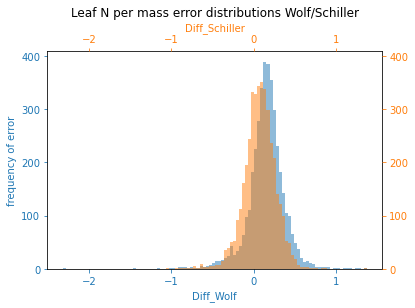

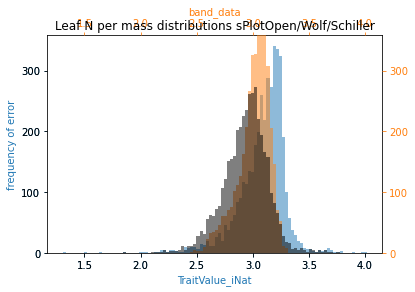

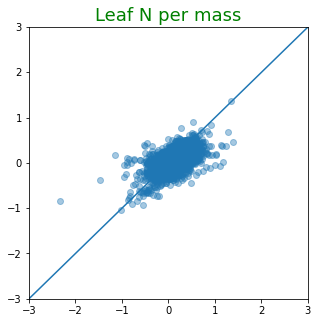

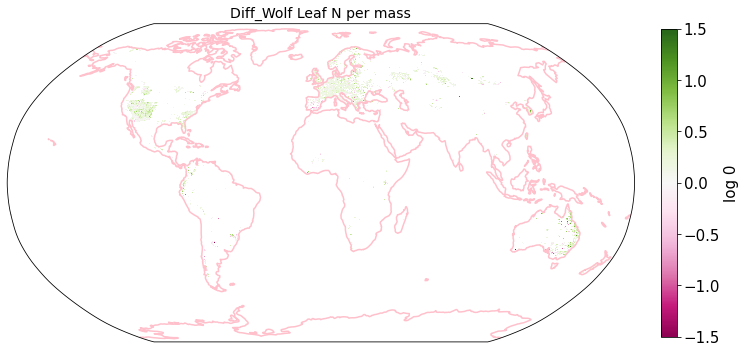

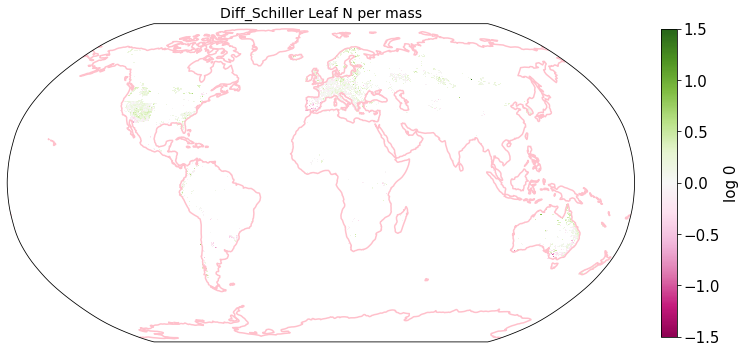

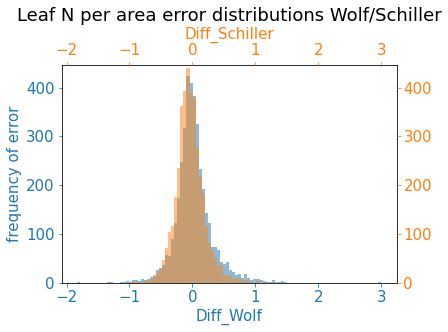

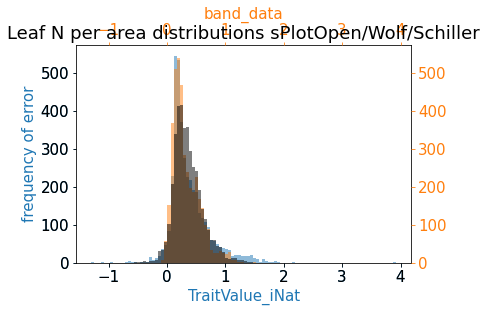

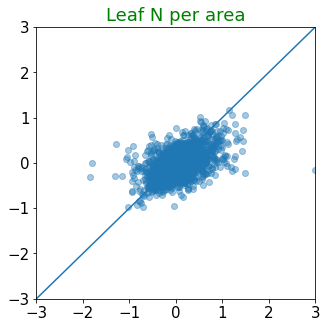

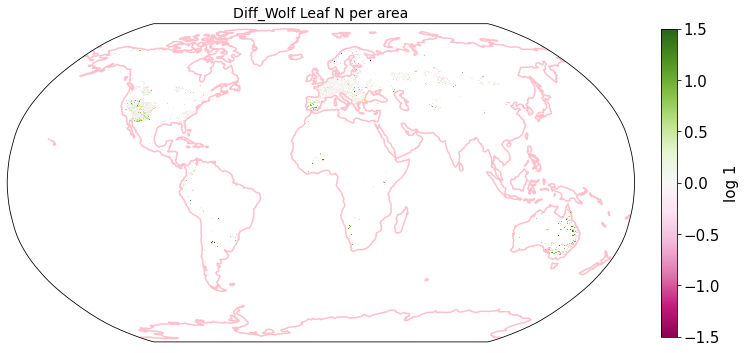

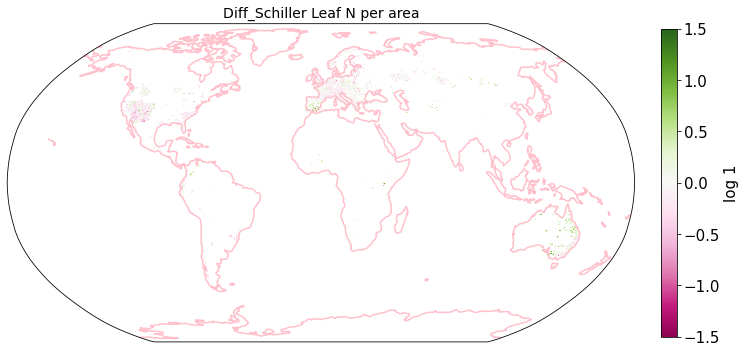

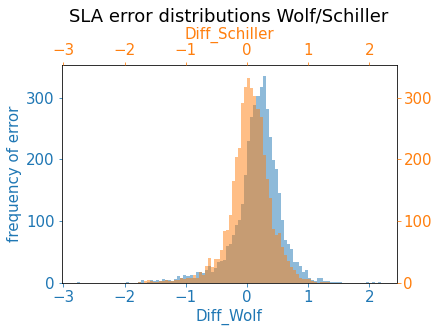

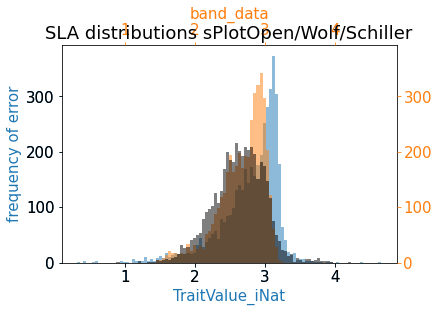

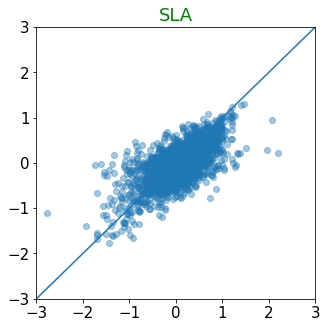

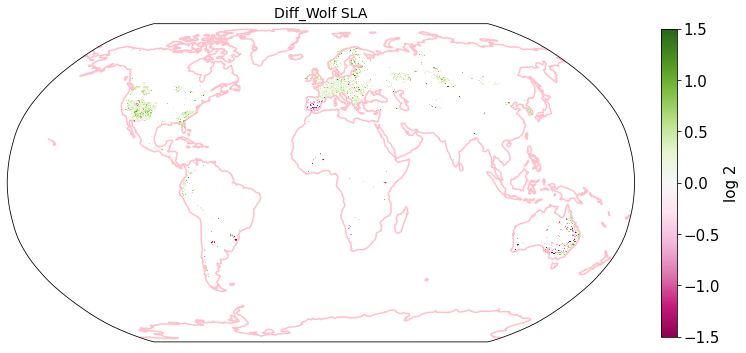

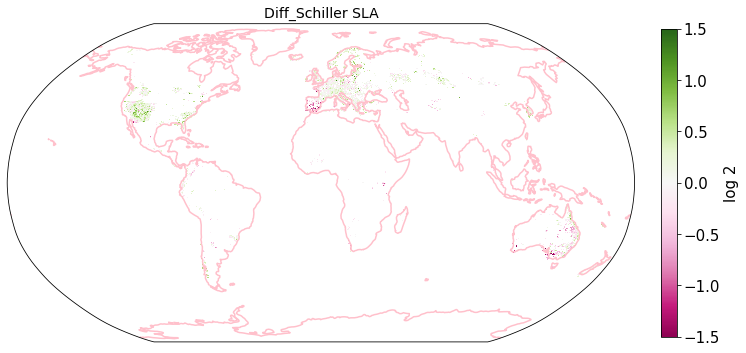

In [17]:
#other_trait = ['other_nit_2deg', 'other_nita_2deg', 'other_sla_2deg']
#trait = ['Leaf N per mass', 'Leaf N per area', 'SLA']


for b in [6]:
    
    for t in [0,1,2]:
        
        b = 4
        if t==2:
            b=6
        # open sPlotData

        filename="grid_means_" + str(deg) + "_deg.csv"
        raster_means = pd.read_csv(filename)
        raster_means = raster_means[~raster_means.isin([np.nan, np.inf, -np.inf]).any(1)]
        
        # subset only one trait
        raster_means_trait = raster_means[raster_means['Trait']==trait[t]]
        

        # published data
        
        
        df = da.sel(band = b).band_data.sel(variable = other_trait[t]).to_dataset().to_dataframe().reset_index()
        df['variable'] = trait[t]
        df['band_data'] = np.log(df['band_data'])        
        
        raster_means_trait = pd.merge(raster_means_trait, df, left_on = ["Trait","x_bin", "y_bin"], right_on = ["variable", "x", "y"])
        raster_means_trait.drop(["variable", "x", "y", "spatial_ref", "band"], axis=1, inplace=True)
            
        # drop nan's
        raster_means_trait = raster_means_trait.dropna()
        

        # difference maps
        raster_means_trait["Diff_Wolf"] = raster_means_trait["TraitValue_iNat"] - raster_means_trait["TraitValue_sPlot"]
        raster_means_trait["Diff_Schiller"] = raster_means_trait["band_data"] - raster_means_trait["TraitValue_sPlot"]
        
        # plot error distribution
        plot_hist_overlay(raster_means_trait, "Diff_Wolf", "Diff_Schiller", trait[t])
        
        print(np.median(raster_means_trait["Diff_Wolf"]))
        print(np.median(raster_means_trait["Diff_Schiller"]))
        
        plot_hist_overlay_3(raster_means_trait, "TraitValue_iNat", "band_data", "TraitValue_sPlot", trait[t])
        
        from scipy.stats import ks_2samp
        print(ks_2samp(raster_means_trait["TraitValue_sPlot"], raster_means_trait["TraitValue_iNat"]))
        print(ks_2samp(raster_means_trait["TraitValue_sPlot"], raster_means_trait["band_data"]))
        
        import scipy.stats as stats
        print(stats.ttest_ind(a=raster_means_trait["TraitValue_sPlot"], b=raster_means_trait["TraitValue_iNat"], equal_var=True))
        print(stats.ttest_ind(a=raster_means_trait["TraitValue_sPlot"], b=raster_means_trait["band_data"], equal_var=True))



        
        
        # adjust coordinates to upper left corner of grid cell
        #raster_means_trait['y_bin'] -= (deg/2)
        #raster_means_trait['x_bin'] += (deg/2)
        
        # plot differences against eachother
        
        fig = plt.figure(figsize=(5, 5))
        ax = plt.scatter(raster_means_trait["Diff_Wolf"], raster_means_trait["Diff_Schiller"], alpha = 0.4)
        plt.axline([0,0], [1,1])
        plt.xlim(-3,3)
        plt.ylim(-3, 3)
        plt.title(label=trait[t],fontsize=18,color="green")
        
        
        
        
        fig = plt.figure(figsize=(12, 12))
        plot_grid(raster_means_trait, 'x_bin', 'y_bin', 'Diff_Wolf', trait[t], deg=deg, log=True)
        
        fig = plt.figure(figsize=(12, 12))
        plot_grid(raster_means_trait, 'x_bin', 'y_bin', 'Diff_Schiller', trait[t], deg=deg, log=True)
        
        
        